# DM - Classification [TASK 3]

Library imports and initial settings.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

from wittgenstein import RIPPER
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
from sklearn.model_selection import GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.svm import SVC

from tensorflow import keras
from scikeras.wrappers import KerasClassifier

from utils import fetch_preprocessed_dataset, store_preprocessed_dataset, build_grid_plot

import sys
import logging as lg
import warnings

warnings.filterwarnings("ignore")

root = lg.getLogger()
root.setLevel(lg.INFO)

handler = lg.StreamHandler(sys.stdout)
handler.setLevel(lg.DEBUG)
formatter = lg.Formatter("%(asctime)s - %(name)s - %(levelname)s - %(message)s")
handler.setFormatter(formatter)
root.addHandler(handler)

Fetching users_num dataset saved in classification phase.

In [2]:
# Load the users_num dataset from csv
dataset = fetch_preprocessed_dataset(step_name="users_total")
users_num = dataset['users_num.csv']

`users_num` is a dataset composed by numerical attributes of `users`.

In [3]:
users_num.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11508 entries, 0 to 11507
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   Unnamed: 0                  11508 non-null  int64  
 1   statuses_count              11508 non-null  int64  
 2   bot                         11508 non-null  int64  
 3   tweets_num                  11508 non-null  int64  
 4   tweets_2020_num             11508 non-null  int64  
 5   likes_num                   11508 non-null  float64
 6   comments_num                11508 non-null  float64
 7   ratio_likes_x_tweets        11508 non-null  float64
 8   entropy                     11508 non-null  float64
 9   texts_mean_length           11508 non-null  float64
 10  texts_special_chars_length  11508 non-null  float64
 11  mean_pub_range              11508 non-null  float64
 12  mean_texts_similarity       11508 non-null  float64
dtypes: float64(8), int64(5)
memory 

## Dataset preparation

Splitting dataset in training and test set. Each of the two part is a couple of input values and labels.

In [4]:
dataset = users_num.copy()
label = dataset.pop('bot')
train_set, test_set, train_label, test_label = train_test_split(dataset, label, stratify =label, test_size=0.20)

print("train_set:", train_set.shape)
print("train_label:", train_label.shape)
print("test_set:", test_set.shape)
print("test_label:", test_label.shape)

train_set: (9206, 12)
train_label: (9206,)
test_set: (2302, 12)
test_label: (2302,)


## Classification models

Dictionary used to collect models predictions in order to compare them in the end of the analysis.

In [5]:
predictions = {}

In [6]:
scaler = StandardScaler()
scaler.fit(train_set, test_set)

train_set_scaled = scaler.transform(train_set)
test_set_scaled = scaler.transform(test_set)

In [7]:
def gridsearch(train_set, train_label, model, param_grid):
    gs = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=4)
    return gs.fit(train_set, train_label)

In [8]:
def report_scores(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    print("TRAIN")
    print(metrics.classification_report(tr_label,
                            train_pred,
                            target_names=['user', 'bot']))
    print("TEST")
    print(metrics.classification_report(ts_label,
                            test_pred,
                            target_names=['user', 'bot']))

In [9]:
def plot_cms(train_pred, test_pred, tr_label=train_label, ts_label=test_label):
    def plot_cm(title, label, pred):
        cm = metrics.confusion_matrix(label, pred)
        disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['user', 'bot'])
        disp.plot()
        disp.ax_.set_title(title)

    plot_cm("TRAIN", tr_label, train_pred)
    plot_cm("TEST", ts_label, test_pred)

### Decision tree

In [10]:
params = dict(
    max_depth=[5, 10, 20, 30, 40, 50],
    min_samples_leaf=[1, 2, 3, 4, 5]
)
dt = DecisionTreeClassifier(criterion='gini', splitter='best')
scores = gridsearch(train_set, train_label, dt, params)

scores

GridSearchCV(cv=4, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'max_depth': [5, 10, 20, 30, 40, 50],
                         'min_samples_leaf': [1, 2, 3, 4, 5]})

In [11]:
scores.best_params_

{'max_depth': 10, 'min_samples_leaf': 2}

In [12]:
dt = DecisionTreeClassifier(criterion='gini', splitter='best', **scores.best_params_)
dt.fit(train_set, train_label)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=2)

In [13]:
train_pred_dt = dt.predict(train_set)
test_pred_dt = dt.predict(test_set)

predictions["Decision tree"] = (train_pred_dt, test_pred_dt)

In [14]:
report_scores(train_pred_dt, test_pred_dt)

TRAIN
              precision    recall  f1-score   support

        user       0.97      0.74      0.84      4313
         bot       0.81      0.98      0.89      4893

    accuracy                           0.87      9206
   macro avg       0.89      0.86      0.86      9206
weighted avg       0.89      0.87      0.87      9206

TEST
              precision    recall  f1-score   support

        user       0.90      0.69      0.78      1079
         bot       0.77      0.93      0.84      1223

    accuracy                           0.82      2302
   macro avg       0.84      0.81      0.81      2302
weighted avg       0.83      0.82      0.81      2302



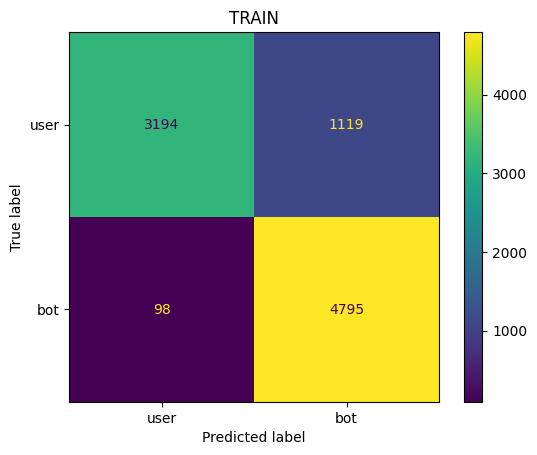

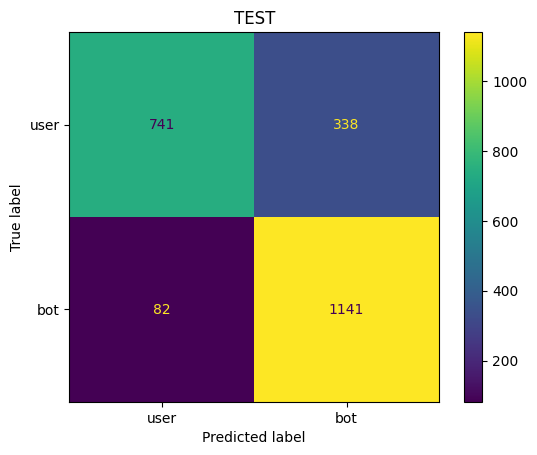

In [15]:
plot_cms(train_pred_dt, test_pred_dt)

### K-nearest neighbors

In [16]:
params = dict(n_neighbors=list(range(1, int(math.sqrt(train_set.shape[0])))))

knn = KNeighborsClassifier()
scores = gridsearch(train_set_scaled, train_label, knn, params)

scores

GridSearchCV(cv=4, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                         13, 14, 15, 16, 17, 18, 19, 20, 21, 22,
                                         23, 24, 25, 26, 27, 28, 29, 30, ...]})

In [17]:
scores.best_params_

{'n_neighbors': 25}

In [18]:
knn = KNeighborsClassifier(**scores.best_params_)
knn = knn.fit(train_set_scaled, train_label)

In [19]:
train_pred_knn = knn.predict(train_set_scaled)
test_pred_knn = knn.predict(test_set_scaled)

predictions["KNN"] = (train_pred_knn, test_pred_knn)

In [20]:
report_scores(train_pred_knn, test_pred_knn)

TRAIN
              precision    recall  f1-score   support

        user       0.91      0.58      0.71      4313
         bot       0.72      0.95      0.82      4893

    accuracy                           0.78      9206
   macro avg       0.82      0.77      0.77      9206
weighted avg       0.81      0.78      0.77      9206

TEST
              precision    recall  f1-score   support

        user       0.88      0.55      0.68      1079
         bot       0.70      0.93      0.80      1223

    accuracy                           0.75      2302
   macro avg       0.79      0.74      0.74      2302
weighted avg       0.79      0.75      0.74      2302



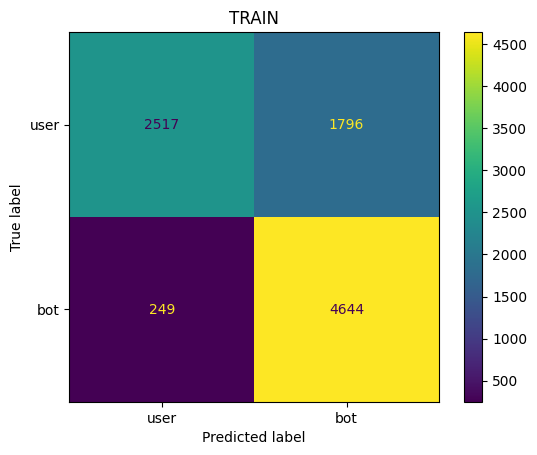

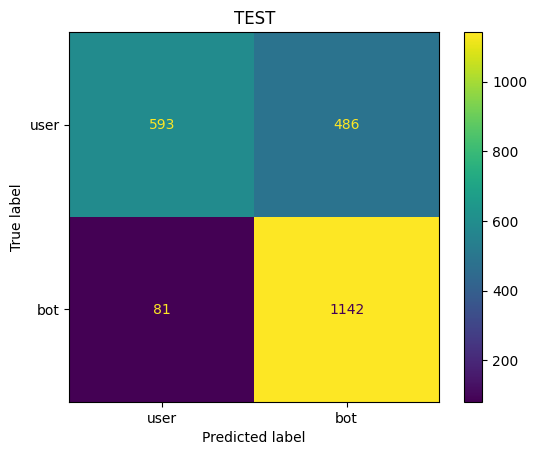

In [21]:
plot_cms(train_pred_knn, test_pred_knn)

### Rule-based

In [22]:
# RIPPER doesn't work with entropy rounded more than 4
train_set_rb = train_set.copy()
train_set_rb['entropy'] = train_set_rb['entropy'].map(lambda x: round(x, 4))

In [23]:
params = dict(
    k=[1, 2, 3],
    prune_size=[0.2, 0.33, 0.5]
)

rb = RIPPER(random_state=0)
scores = gridsearch(train_set_rb, train_label, rb, params)

scores

/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  covered = covered.append(rule.covers(df))
/Users/geremiapompei/Library/CloudStorage/OneDrive-UniversityofPisa/UNIPI/2_anno_2022_2023/1_semestre/data_mining/exam/data-mining/venv/lib/python3.10/site-packages/wittgenstein/base.py:127: FutureWarning: The frame.append method is deprecated and will be removed 

GridSearchCV(cv=4,
             estimator=<RIPPER(k=2, prune_size=0.33, max_rule_conds=None, verbosity=0, max_total_conds=None, dl_allowance=64, random_state=0, n_discretize_bins=10, max_rules=None)>,
             n_jobs=-1,
             param_grid={'k': [1, 2, 3], 'prune_size': [0.2, 0.33, 0.5]})

In [24]:
scores.best_params_

{'k': 1, 'prune_size': 0.33}

In [25]:
rb = RIPPER(random_state=0, **scores.best_params_)
rb.fit(train_set_rb, y=train_label)

List of rules discovered with ripper algorithm.

In [26]:
rb.out_model()

[[entropy=<0.0001 ^ statuses_count=20.0-35.0 ^ mean_texts_similarity=0.0045-0.0079 ^ texts_special_chars_length=7.5-11.15 ^ mean_pub_range=>811894.94 ^ likes_num=<1.0] V
[entropy=<0.0001 ^ statuses_count=20.0-35.0 ^ mean_texts_similarity=0.0045-0.0079 ^ ratio_likes_x_tweets=>0.97] V
[entropy=<0.0001 ^ statuses_count=<20.0 ^ texts_special_chars_length=7.5-11.15] V
[entropy=<0.0001 ^ statuses_count=35.0-45.0] V
[entropy=0.0001-0.0002 ^ statuses_count=45.0-58.0] V
[entropy=<0.0001 ^ statuses_count=<20.0 ^ mean_texts_similarity=<0.0045 ^ texts_special_chars_length=<3.4] V
[mean_texts_similarity=0.021-0.023 ^ texts_special_chars_length=5.43-5.84 ^ texts_mean_length=82.14-89.47] V
[entropy=0.0001-0.0002 ^ statuses_count=35.0-45.0 ^ Unnamed:0=>10375.5] V
[entropy=<0.0001 ^ statuses_count=20.0-35.0] V
[entropy=0.0001-0.0002 ^ texts_special_chars_length=3.72-3.96 ^ likes_num=4.0-6.0 ^ statuses_count=35.0-45.0] V
[entropy=0.0001-0.0002 ^ mean_texts_similarity=0.014-0.015 ^ tweets_num=102.0-121.0

In [27]:
train_pred_rb = rb.predict(train_set)
test_pred_rb = rb.predict(test_set)

predictions["Rule-based"] = (train_pred_rb, test_pred_rb)

In [28]:
report_scores(train_pred_rb, test_pred_rb)

TRAIN
              precision    recall  f1-score   support

        user       0.75      0.71      0.73      4313
         bot       0.76      0.79      0.77      4893

    accuracy                           0.75      9206
   macro avg       0.75      0.75      0.75      9206
weighted avg       0.75      0.75      0.75      9206

TEST
              precision    recall  f1-score   support

        user       0.77      0.68      0.72      1079
         bot       0.74      0.83      0.78      1223

    accuracy                           0.76      2302
   macro avg       0.76      0.75      0.75      2302
weighted avg       0.76      0.76      0.75      2302



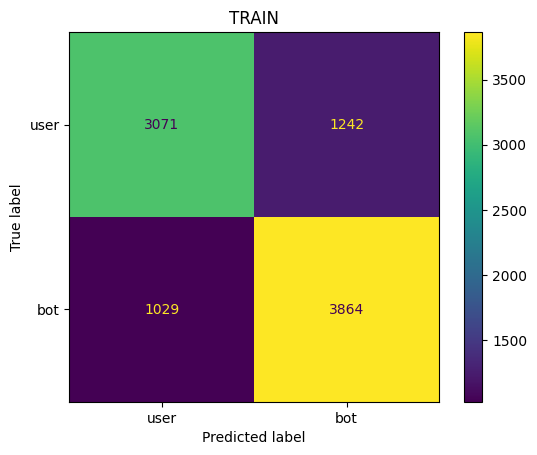

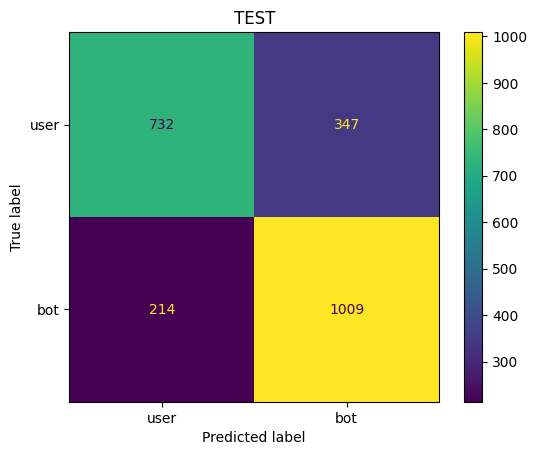

In [29]:
plot_cms(train_pred_rb, test_pred_rb)

### Naive Bayes

In [30]:
nb = GaussianNB()
nb.fit(train_set, train_label)

GaussianNB()

In [31]:
train_pred_nb = nb.predict(train_set)
test_pred_nb = nb.predict(test_set)

predictions["Naive Bayes"] = (train_pred_nb, test_pred_nb)

In [32]:
report_scores(train_pred_nb, test_pred_rb)

TRAIN
              precision    recall  f1-score   support

        user       0.71      0.29      0.41      4313
         bot       0.59      0.90      0.71      4893

    accuracy                           0.61      9206
   macro avg       0.65      0.59      0.56      9206
weighted avg       0.65      0.61      0.57      9206

TEST
              precision    recall  f1-score   support

        user       0.77      0.68      0.72      1079
         bot       0.74      0.83      0.78      1223

    accuracy                           0.76      2302
   macro avg       0.76      0.75      0.75      2302
weighted avg       0.76      0.76      0.75      2302



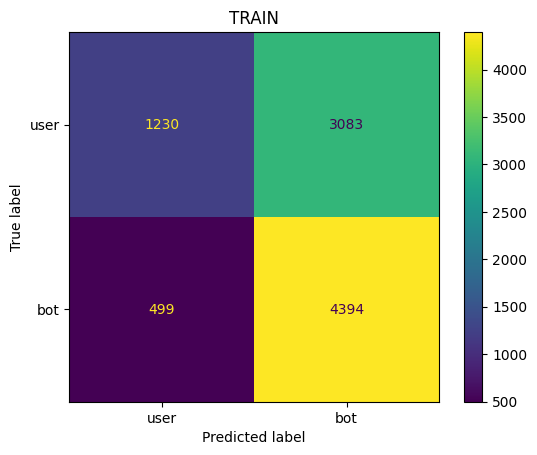

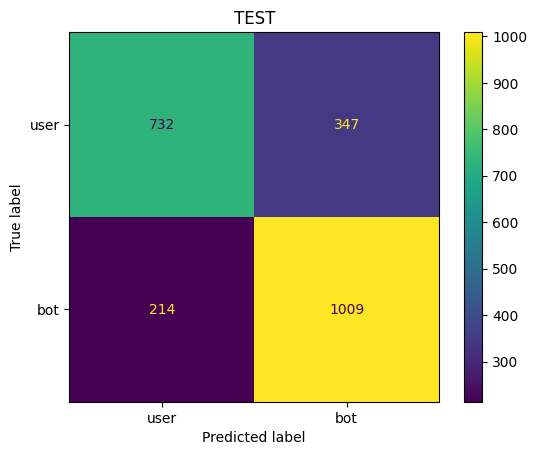

In [33]:
plot_cms(train_pred_nb, test_pred_rb)

### Ensemble methods

#### AdaBoost

In [34]:
params = dict(
    n_estimators=list(range(10, 201, 10)),
    learning_rate=[0.1, 0.3, 0.05, 0.01]
)

boost = AdaBoostClassifier()
scores = gridsearch(train_set, train_label, boost, params)

scores

GridSearchCV(cv=4, estimator=AdaBoostClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.3, 0.05, 0.01],
                         'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200]})

In [35]:
scores.best_params_

{'learning_rate': 0.3, 'n_estimators': 200}

In [36]:
boost = AdaBoostClassifier(**scores.best_params_)
boost.fit(train_set, train_label)

AdaBoostClassifier(learning_rate=0.3, n_estimators=200)

In [37]:
train_pred_boost = boost.predict(train_set)
test_pred_boost = boost.predict(test_set)

predictions["AdaBoost"] = (train_pred_boost, test_pred_boost)

In [38]:
report_scores(train_pred_boost, test_pred_boost)

TRAIN
              precision    recall  f1-score   support

        user       0.92      0.69      0.79      4313
         bot       0.78      0.95      0.86      4893

    accuracy                           0.83      9206
   macro avg       0.85      0.82      0.82      9206
weighted avg       0.85      0.83      0.83      9206

TEST
              precision    recall  f1-score   support

        user       0.92      0.68      0.78      1079
         bot       0.77      0.95      0.85      1223

    accuracy                           0.82      2302
   macro avg       0.84      0.81      0.81      2302
weighted avg       0.84      0.82      0.82      2302



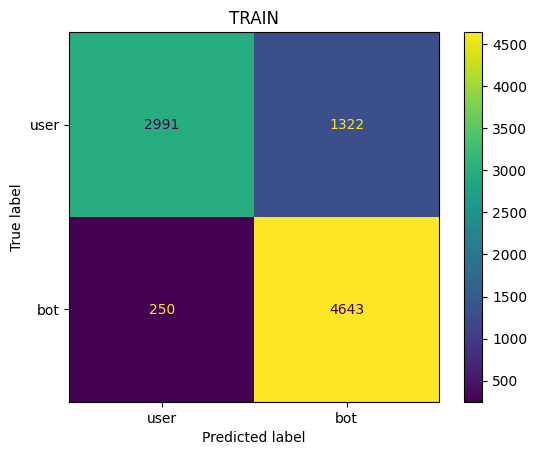

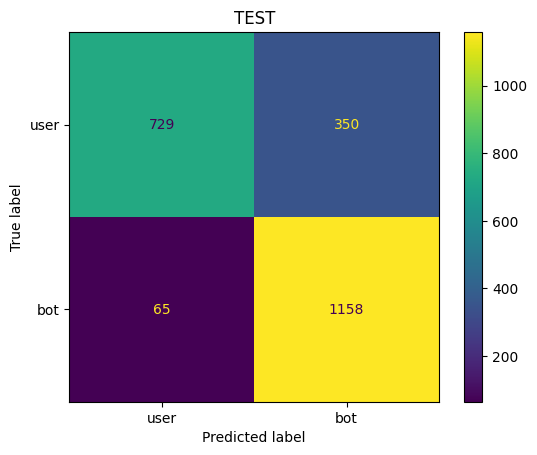

In [39]:
plot_cms(train_pred_boost, test_pred_boost)

#### Random forest

In [40]:
params = dict(n_estimators=list(range(10, 201, 10)))

rf = RandomForestClassifier()
scores = gridsearch(train_set, train_label, rf, params)

scores

GridSearchCV(cv=4, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90,
                                          100, 110, 120, 130, 140, 150, 160,
                                          170, 180, 190, 200]})

In [41]:
scores.best_params_

{'n_estimators': 140}

In [42]:
rf = RandomForestClassifier(**scores.best_params_)
rf.fit(train_set, train_label)

RandomForestClassifier(n_estimators=140)

In [43]:
train_pred_rf = rf.predict(train_set)
test_pred_rf = rf.predict(test_set)

predictions["Random forest"] = (train_pred_rf, test_pred_rf)

In [44]:
report_scores(train_pred_rf, test_pred_rf)

TRAIN
              precision    recall  f1-score   support

        user       1.00      1.00      1.00      4313
         bot       1.00      1.00      1.00      4893

    accuracy                           1.00      9206
   macro avg       1.00      1.00      1.00      9206
weighted avg       1.00      1.00      1.00      9206

TEST
              precision    recall  f1-score   support

        user       0.89      0.70      0.79      1079
         bot       0.78      0.93      0.85      1223

    accuracy                           0.82      2302
   macro avg       0.84      0.81      0.82      2302
weighted avg       0.83      0.82      0.82      2302



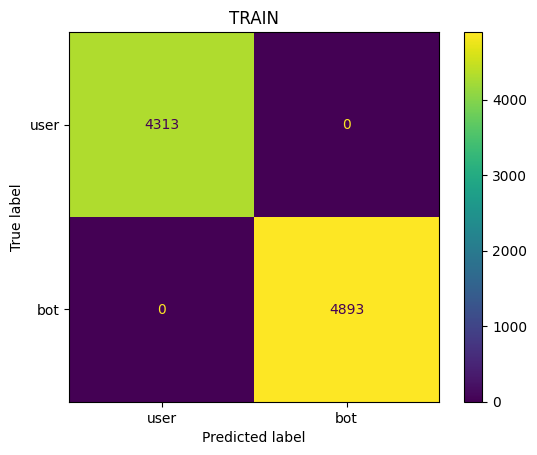

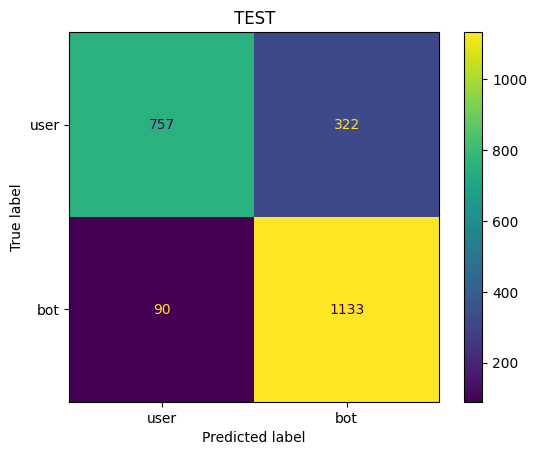

In [45]:
plot_cms(train_pred_rf, test_pred_rf)

### SVM

In [46]:
params = dict(
    kernel=['rbf', 'sigmoid'],
    C=[1, 2, 5]
)

svm = SVC()
scores = gridsearch(train_set_scaled, train_label, svm, params)

scores

GridSearchCV(cv=4, estimator=SVC(), n_jobs=-1,
             param_grid={'C': [1, 2, 5], 'kernel': ['rbf', 'sigmoid']})

In [47]:
scores.best_params_

{'C': 5, 'kernel': 'rbf'}

In [48]:
svm = SVC(**scores.best_params_)
svm.fit(train_set_scaled, train_label)

SVC(C=5)

In [49]:
train_pred_svm = svm.predict(train_set_scaled)
test_pred_svm = svm.predict(test_set_scaled)

predictions["SVM"] = (train_pred_svm, test_pred_svm)

In [50]:
report_scores(train_pred_svm, test_pred_svm)

TRAIN
              precision    recall  f1-score   support

        user       0.96      0.59      0.73      4313
         bot       0.73      0.98      0.84      4893

    accuracy                           0.80      9206
   macro avg       0.84      0.78      0.78      9206
weighted avg       0.84      0.80      0.79      9206

TEST
              precision    recall  f1-score   support

        user       0.92      0.56      0.70      1079
         bot       0.71      0.96      0.82      1223

    accuracy                           0.77      2302
   macro avg       0.82      0.76      0.76      2302
weighted avg       0.81      0.77      0.76      2302



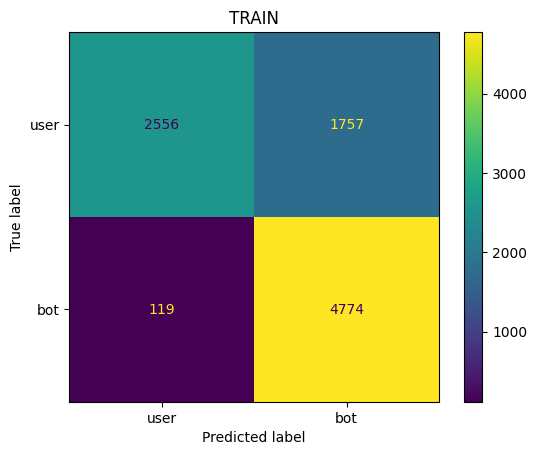

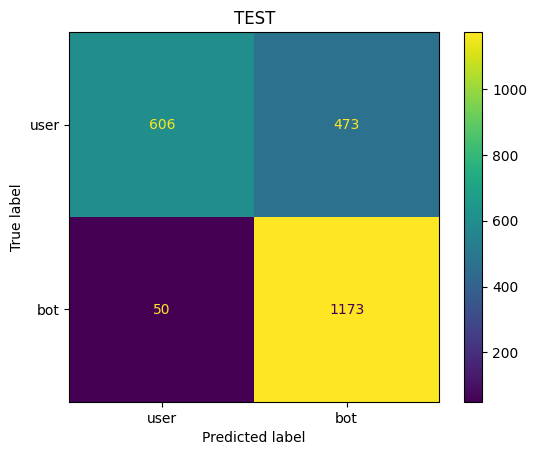

In [51]:
plot_cms(train_pred_svm, test_pred_svm)

### Neural network

In [52]:
x_train_nn = np.reshape(train_set_scaled, (-1, 1, train_set.shape[1]))
x_test_nn = np.reshape(test_set_scaled, (-1, 1, test_set.shape[1]))
y_train_nn = np.asarray(train_label).reshape((-1,1))
y_test_nn = np.asarray(test_label).reshape((-1,1))

In [53]:
def create_nn(hidden_units, hidden_activation):
    nn = keras.models.Sequential([
            keras.layers.Flatten(input_shape=(1, train_set.shape[1])),
            keras.layers.Dense(hidden_units, activation=hidden_activation),
            keras.layers.Dense(1, activation='sigmoid')
        ])
    nn.compile(optimizer='adam',
                      loss='mean_squared_error',
                      metrics=['accuracy'])

    return nn

In [54]:
params = dict(
    model__hidden_units=[32, 64, 128, 516, 1024, 2048],
    model__hidden_activation=['sigmoid', 'relu', 'tanh']
)

nn = KerasClassifier(model=create_nn, epochs = 100, batch_size = 516)
scores = gridsearch(x_train_nn, y_train_nn, nn, params)

scores

2023-01-05 03:09:23.457863: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 03:09:23.457881: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 03:09:23.457896: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 03:09:23.457863: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 03:09:23.464171: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 03:09:23.465047: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 03:09:23.468486: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-05 03:09:23.472672: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
Epoch 1/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2586 - accuracy: 0.5296
Epoch 2/100
14/14 [==============================] - 0s 934us/step - loss: 0.3034 - accuracy: 0.5319
Epoch 3/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2453 - accuracy: 0.6279
Epoch 3/100
Epoch 3/100
14/14 [==============================] - 0s 922us/step - loss: 0.2770 - accuracy: 0.5319
Epoch 4/100
14/14 [==============================] - 0s 968us/step - loss: 0.2372 - accuracy: 0.6453
Epoch 4/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2362 - accuracy: 0.6490
Epoch 4/100
14/14 [==============================] - 0s 838us/step - loss: 0.2544 - accuracy: 0.5380
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2498 - accuracy: 0.5390
Epoch 2/100
14/14 [==============================] - 0s 987us/step - loss: 0.2314 - accuracy: 0.6637
Epo

2023-01-05 03:09:28.662151: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 1/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2581 - accuracy: 0.4935
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2393 - accuracy: 0.5710
Epoch 3/100
 1/14 [=>............................] - ETA: 0s - loss: 0.2313 - accuracy: 0.6705

2023-01-05 03:09:28.990132: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 3ms/step - loss: 0.2297 - accuracy: 0.6606
Epoch 4/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2250 - accuracy: 0.6663
Epoch 5/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2223 - accuracy: 0.6789
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2207 - accuracy: 0.6824
Epoch 7/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2196 - accuracy: 0.6868
Epoch 8/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2188 - accuracy: 0.6912
Epoch 9/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2181 - accuracy: 0.6932
Epoch 10/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2175 - accuracy: 0.6945
Epoch 11/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2387 - accuracy: 0.6157
Epoch 2/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2170 - accuracy: 0.6897
Epoch 12/100
14/14 [

2023-01-05 03:09:29.577027: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 2ms/step - loss: 0.2166 - accuracy: 0.6824
Epoch 17/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2131 - accuracy: 0.6931
Epoch 26/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2164 - accuracy: 0.6793
Epoch 18/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2129 - accuracy: 0.6916
Epoch 27/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2161 - accuracy: 0.6851
Epoch 19/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2128 - accuracy: 0.6906
Epoch 28/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2158 - accuracy: 0.6824
Epoch 20/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2125 - accuracy: 0.6928
Epoch 29/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2157 - accuracy: 0.6805
Epoch 21/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2122 - accuracy: 0.6921
Epoch 30/100


2023-01-05 03:09:29.969932: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 2ms/step - loss: 0.2120 - accuracy: 0.6873
Epoch 36/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2083 - accuracy: 0.6957
Epoch 15/100
Epoch 47/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2114 - accuracy: 0.6850
Epoch 37/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2082 - accuracy: 0.6938
Epoch 48/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2169 - accuracy: 0.6818
Epoch 16/100
14/14 [==============================] - 0s 833us/step - loss: 0.2078 - accuracy: 0.7003
Epoch 49/100
Epoch 38/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2167 - accuracy: 0.6781
Epoch 17/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2076 - accuracy: 0.6945
Epoch 50/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2111 - accuracy: 0.6837
Epoch 39/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2165 - ac

2023-01-05 03:09:30.407792: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 3ms/step - loss: 0.2107 - accuracy: 0.6820
Epoch 38/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2042 - accuracy: 0.6934
Epoch 59/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1999 - accuracy: 0.7092
Epoch 71/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2159 - accuracy: 0.6882
Epoch 11/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2039 - accuracy: 0.6958
Epoch 60/100
14/14 [==============================] - 0s 1ms/step - loss: 0.1991 - accuracy: 0.7052
Epoch 73/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2100 - accuracy: 0.6844
Epoch 40/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2035 - accuracy: 0.6970
Epoch 61/100
14/14 [==============================] - 0s 1ms/step - loss: 0.1987 - accuracy: 0.7080
Epoch 12/100
Epoch 74/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2097 - accuracy: 0.6849


2023-01-05 03:09:31.046741: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 2ms/step - loss: 0.2139 - accuracy: 0.6903
Epoch 15/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1953 - accuracy: 0.7244
Epoch 97/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2023 - accuracy: 0.6918
Epoch 84/100
Epoch 61/100
14/14 [==============================] - 0s 4ms/step - loss: 0.2103 - accuracy: 0.6921
Epoch 31/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2020 - accuracy: 0.6947
Epoch 16/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1899 - accuracy: 0.7333
Epoch 98/100
14/14 [==============================] - 0s 3ms/step - loss: 0.1949 - accuracy: 0.7284
Epoch 85/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2102 - accuracy: 0.6894
Epoch 32/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2132 - accuracy: 0.6890
Epoch 17/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1894 - accuracy: 0.7430


2023-01-05 03:09:31.424926: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


Epoch 94/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2220 - accuracy: 0.6813
Epoch 5/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1980 - accuracy: 0.7067
Epoch 72/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2072 - accuracy: 0.6946
Epoch 42/100
14/14 [==============================] - 0s 1ms/step - loss: 0.1918 - accuracy: 0.7371
Epoch 95/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2118 - accuracy: 0.6868
Epoch 25/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2213 - accuracy: 0.6802
Epoch 43/100
14/14 [==============================] - 0s 1ms/step - loss: 0.1915 - accuracy: 0.7378
Epoch 6/100
Epoch 96/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2115 - accuracy: 0.6915
Epoch 26/100
14/14 [==============================] - 0s 1ms/step - loss: 0.2068 - accuracy: 0.6917
Epoch 44/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1973 - accura

2023-01-05 03:09:31.880540: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


14/14 [==============================] - 0s 3ms/step - loss: 0.2083 - accuracy: 0.6902
Epoch 37/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2149 - accuracy: 0.6821
Epoch 19/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2193 - accuracy: 0.6804
Epoch 6/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2008 - accuracy: 0.7014
Epoch 59/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1922 - accuracy: 0.7296
Epoch 89/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2147 - accuracy: 0.6811
Epoch 20/100
14/14 [==============================] - 0s 3ms/step - loss: 0.2085 - accuracy: 0.6932
Epoch 38/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2005 - accuracy: 0.7044
Epoch 60/100
14/14 [==============================] - 0s 2ms/step - loss: 0.1918 - accuracy: 0.7322
Epoch 90/100
14/14 [==============================] - 0s 2ms/step - loss: 0.2000 - accuracy: 0.7015
Epoch 61/100
1

2023-01-05 03:10:19.849523: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


18/18 [==============================] - 0s 2ms/step - loss: 0.2263 - accuracy: 0.6403
Epoch 2/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2022 - accuracy: 0.6937
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1913 - accuracy: 0.7152
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1842 - accuracy: 0.7491
Epoch 5/100
18/18 [==============================] - 0s 1ms/step - loss: 0.1787 - accuracy: 0.7562
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1745 - accuracy: 0.7627
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1717 - accuracy: 0.7657
Epoch 8/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1691 - accuracy: 0.7683
Epoch 9/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1667 - accuracy: 0.7696
Epoch 10/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1650 - accuracy: 0.7741
Epoch 11/100
18/18 [=

GridSearchCV(cv=4,
             estimator=KerasClassifier(batch_size=516, epochs=100, model=<function create_nn at 0x28c2ca3b0>),
             n_jobs=-1,
             param_grid={'model__hidden_activation': ['sigmoid', 'relu',
                                                      'tanh'],
                         'model__hidden_units': [32, 64, 128, 516, 1024, 2048]})

In [55]:
scores.best_params_

{'model__hidden_activation': 'relu', 'model__hidden_units': 1024}

In [56]:
best_params = {k.replace('model__', ''): v for k, v in scores.best_params_.items()}

nn = create_nn(**best_params)
nn.fit(x_train_nn, y_train_nn, epochs = 100, batch_size = 516)

Epoch 1/100
18/18 [==============================] - 0s 2ms/step - loss: 0.2201 - accuracy: 0.6683
Epoch 2/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1996 - accuracy: 0.6953
Epoch 3/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1894 - accuracy: 0.7297
Epoch 4/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1827 - accuracy: 0.7507
Epoch 5/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1774 - accuracy: 0.7587
Epoch 6/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1738 - accuracy: 0.7603
Epoch 7/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1712 - accuracy: 0.7655
Epoch 8/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1681 - accuracy: 0.7678
Epoch 9/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1658 - accuracy: 0.7723
Epoch 10/100
18/18 [==============================] - 0s 2ms/step - loss: 0.1637 - accuracy: 0.7729
Epoch 11/

In [57]:
train_pred_nn = (nn.predict(x_train_nn) > 0.5).astype("int32")
test_pred_nn = (nn.predict(x_test_nn) > 0.5).astype("int32")

predictions["Neural network"] = (train_pred_nn, test_pred_nn)

72/72 [==============================] - 0s 304us/step


In [58]:
report_scores(train_pred_nn, test_pred_nn)

TRAIN
              precision    recall  f1-score   support

        user       0.93      0.64      0.76      4313
         bot       0.75      0.96      0.84      4893

    accuracy                           0.81      9206
   macro avg       0.84      0.80      0.80      9206
weighted avg       0.84      0.81      0.80      9206

TEST
              precision    recall  f1-score   support

        user       0.90      0.61      0.73      1079
         bot       0.73      0.94      0.82      1223

    accuracy                           0.79      2302
   macro avg       0.82      0.78      0.78      2302
weighted avg       0.81      0.79      0.78      2302



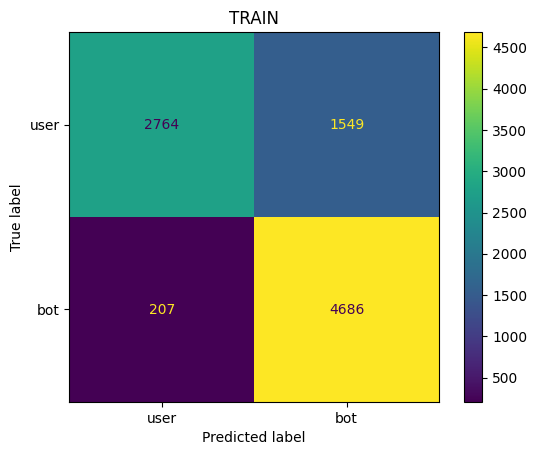

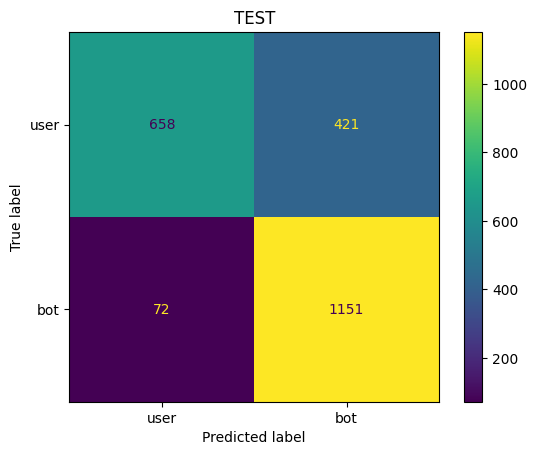

In [59]:
plot_cms(train_pred_nn, test_pred_nn)

## Comparisons

In [60]:
def plot_roc(roc_type="test"):
    plt.figure(0).clf()
    is_test = roc_type == "test"
    index = 1 if is_test else 0

    for key, value in predictions.items():
        pred = value[index]
        label = test_label if is_test else train_label
        fpr, tpr, thresh = metrics.roc_curve(label, pred)
        auc = metrics.roc_auc_score(label, pred)
        plt.plot(fpr,tpr,label=f"{key}, auc="+str(round(auc, 2)))
        plt.title("Test" if is_test else "Train")

    plt.legend(loc=0)

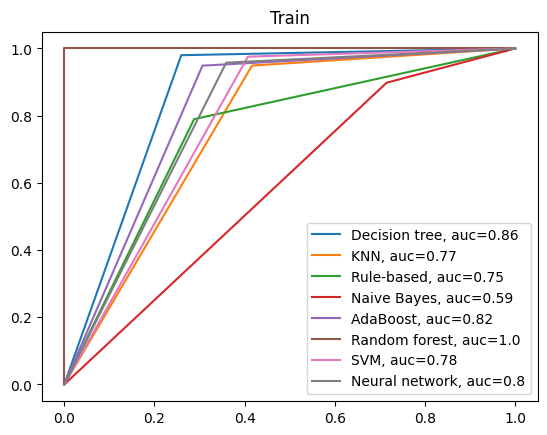

In [61]:
plot_roc("train")

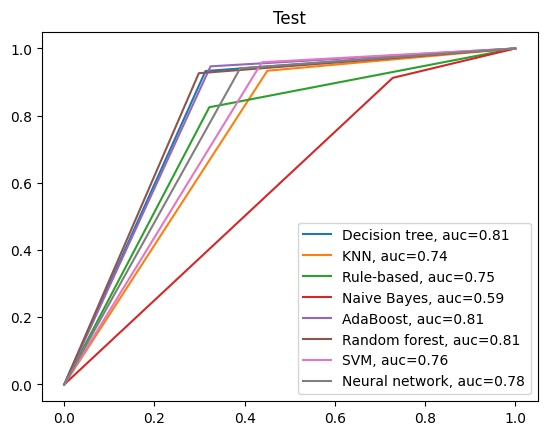

In [62]:
plot_roc("test")